# Домашняя работа: "Методы оптимизации"

ФИО: Филимонов Степан Владиславович

## Описание задания:
Вам необходимо реализовать оставшиеся методы оптимизации, которые разбирались на лекции: <b>Momentum, AdaDelta, Adam</b>. Сравнение методов оптимизации нужно провести на примере из семинара, а также при обучении сверточной нейронной сети на датасете MNIST.



## Задание разделено на следующие части:
1.1 Реализация методов Momentum, AdaDelta, Adam **(1 балл)**

1.2 Сравнение реализованных методов **(1 балл)**

2.1 Реализация сверточной нейронной сети и обучение ее на MNIST **(2 балла)**

2.2 Сравнение графиков обучения для нейросети на реализованных методах **(1 балл)**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 10 октября.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

## Часть 1: Реализация методов

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

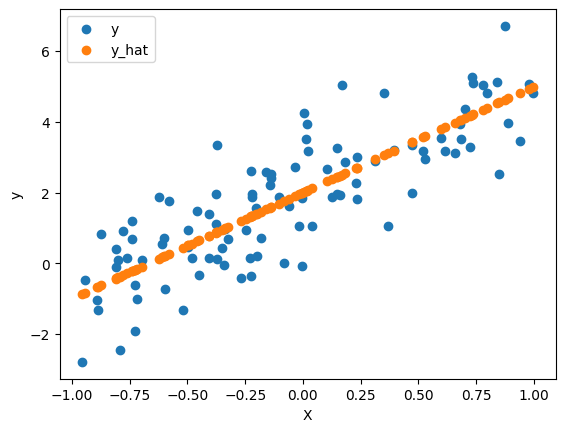

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

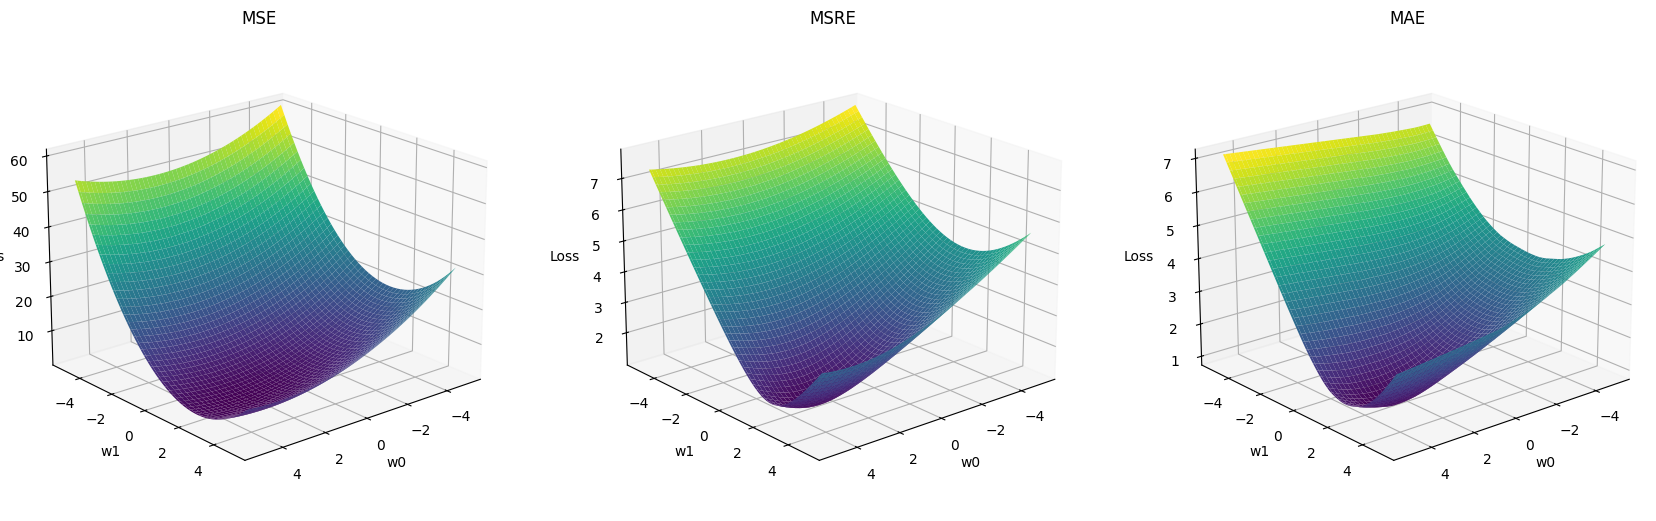

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()

In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

Реализация методов SGD и AdaGrad с семинара:

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is None:
                    continue
                p -= self.lr * p.grad

In [9]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)
        self.epsilon = epsilon
        self.eta = eta

        self.G = [0] * len(self.params)

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self.G[i] += p.grad ** 2

                p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### 1.1 Реализуйте методы Momentum, AdaDelta, Adam. **(1 балл)**

#### Momentum
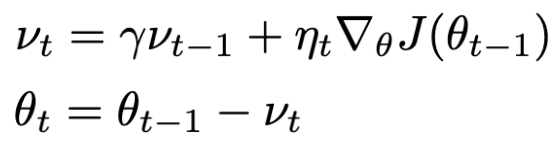

In [10]:
class Momentum(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self._learning_rate = lr
        self._gamma = gamma
        self._v = [ torch.zeros(param.shape) for param in self.params ]

    def __str__(self):
        return f'Momentum метод собственной реализации'
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue
                self._v[i] = self._gamma * self._v[i] + self._learning_rate * p.grad
                p -= self._v[i]

#### AdaDelta
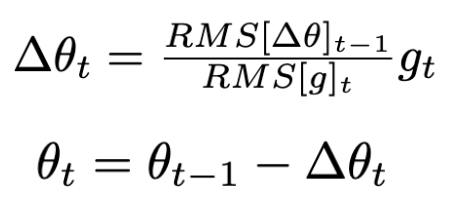

In [11]:
class AdaDelta(Optimizer):
    def __init__(self, params, eps=1e-8, gamma=0.7):
        super().__init__(params)
        self._eps = eps
        self._gamma = gamma

        self._g = [ torch.zeros(param.shape) for param in self.params ]

        # По идеи данный параметр должен быть инициализирован не нулевыми значениями, но в дальнейшем
        # если он не нулевыми значениям инициализирован, то на анимации себе показывает корректно. Но
        # на MNIST не сходится
        self._deltaTheta = [ torch.zeros(param.shape) for param in self.params ]

    def __str__(self):
        return f'AdaDelta метод собственной реализации'

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self._g[i] = self._gamma * self._g[i] + (1 - self._gamma) * (p.grad ** 2)
                deltaTheta = torch.sqrt(self._deltaTheta[i] + self._eps) / torch.sqrt(self._g[i] + self._eps) * p.grad
                self._deltaTheta[i] = self._gamma * self._deltaTheta[i] + (1 - self._gamma) * (deltaTheta ** 2)
                p -= deltaTheta

#### Adam
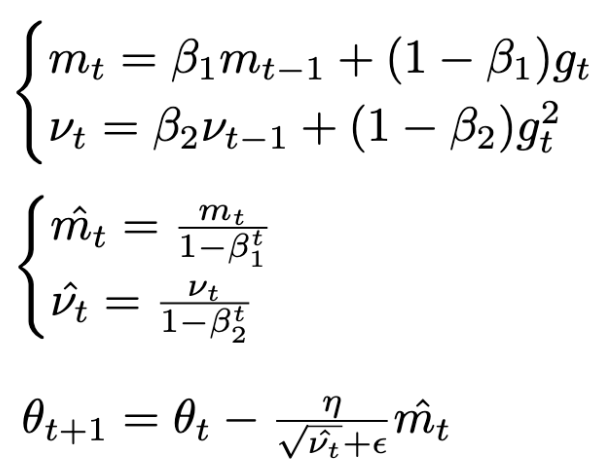

In [12]:
class Adam(Optimizer):
    def __init__(self, params, lr=1e-2, b1=0.9, b2=0.9, eta=1e-8):
        super().__init__(params)
        self._learning_rate = lr
        self._beta1 = b1
        self._beta2 = b2
        self._eta = eta
        self._mt = [ torch.zeros(param.shape) for param in self.params ]
        self._vt = [ torch.zeros(param.shape) for param in self.params ]

    def __str__(self):
        return f'Adam метод собственной реализации'
    
    def _f(self, x, beta, grad):
        return beta * x + (1 - beta) * grad
    
    def _hat(self, x, beta, i):
        return x[i] / (1 - beta ** (i+1))
    
    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is None:
                    continue

                self._mt[i] = self._f(self._mt[i], self._beta1, p.grad)
                self._vt[i] = self._f(self._vt[i], self._beta2, (p.grad**2))
                mt = self._hat(self._mt, self._beta1, i)
                vt = self._hat(self._vt, self._beta2, i)
                p -= self._learning_rate / torch.sqrt(vt + self._eta) * mt

### 1.2 Сравните реализованные методы на предложенном примере **(1 балл)**

In [14]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eps': 1e-8}, start_point=[-4, -4], num_iter=100)

In [15]:
import torch.optim as opt

In [16]:
compare_optimizers(
    loss_animator,
    mse,
    [
        # Семинар
        ['SGD', SGD, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'epsilon': 1e-6, 'eta': 0.9}],
        # ДЗ
        ['Momentum', Momentum, {'lr': 1e-1, 'gamma': 0.9}],
        ['AdaDelta', AdaDelta, {'eps': 1e-8, 'gamma': 0.8}],
        ['Adam', Adam, {'lr': 1e-1, 'b1': 0.9, 'b2': 0.9}],
        # torch
        ['torch.Momentum', opt.SGD, {}],
        ['torch.Adadelta', opt.Adadelta, {}],
        ['torch.Adam', opt.Adam, {'lr': 1e-3, 'betas': (0.9, 0.9)}]
     ],
    start_point=[-4, -4],
    num_iter=100
)

**Вывод:**

1. Очень много зависит от параметров. Например если повысить lr у *Momentum* он будет более плавно сходится, соответственно с остальными аналогично

2. Реализация из torch сходятся долго, это связано с не подобранными параметрами

3. AdaDelta почему-то имеет крайне медленную сходимость...

##  Часть 2: Обучение нейронной сети

### 2.1 Реализуйте сверточную нейронную сеть и обучите ее на MNIST с помощью методов Adam, Adagrad, AdaDelta и SGD. Для обучения используйте оптимизаторы из первой части, а не из pytorch. **(2 балла)**

Скачайте датасет и реализуйте даталоудеры:

In [17]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz
!tar -zxvf MNIST.tar.gz

zsh:1: command not found: wget
tar: Error opening archive: Failed to open 'MNIST.tar.gz'


In [18]:
transform = transforms.Compose([
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('.', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

Выведем скачанное

In [19]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

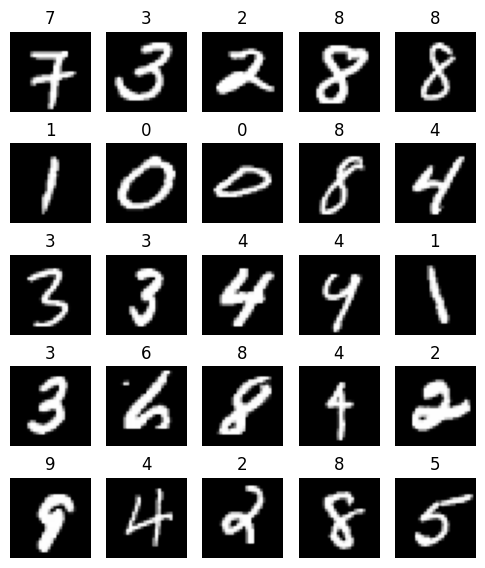

In [20]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(f'{y[i]}')
    plt.axis('off')

Реализуйте сверточную нейронную нейронную сеть по шаблону:

* Используйте сверточные (nn.Conv2d) и полносвязные (nn.Linear) слои
* Не забудьте преобразовать тензор перед подачей в полносвязный слой (x = x.view(-1, d1), где d1 -- размерность входа первого полносвязного слоя)
* Можно использовать dropout (nn.Dropout2d) и функции активации (например, F.relu)
* В конце метода forward необходимо использовать F.log_softmax для предсказания класса изображения

In [21]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=3), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(10, 16, kernel_size=3), nn.ReLU(),
            
            nn.Flatten(),
            nn.Linear(1936, 1000), nn.ReLU(),
            nn.Linear(1000, 10)
        )

    def forward(self, x):
        x = self.layers(x)
        return F.log_softmax(x)

In [22]:
networks = [ Net() for i in range(8) ]
optimizers = [
                SGD(         params=networks[0].parameters()),
                Momentum(    params=networks[1].parameters()),
                AdaGrad(     params=networks[2].parameters()),
                AdaDelta(    params=networks[3].parameters()),
                Adam(        params=networks[4].parameters()),
                opt.SGD(     params=networks[5].parameters()),
                opt.Adadelta(params=networks[6].parameters()),
                opt.Adam(    params=networks[7].parameters()),
            ]

Запустите обучение, постройте график лоссов от эпохи:

In [23]:
networks_losses = [[] for i in range(8)]
for losses, network, optimizer in zip(networks_losses, networks, optimizers):
    print(optimizer)
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()


        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
            1, batch_idx * len(data), len(train_loader.dataset),
             100. * batch_idx / len(train_loader), loss.item()))
            losses.append(loss.item())

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.302683


/var/folders/ll/sf8djrcj0ljd5cltbywtgm9w0000gn/T/ipykernel_18405/1169540507.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.668502
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.742495
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.537126
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.392983
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.125968
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.102956
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.338739
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.415528
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.497213
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.214785
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.130437
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.349576
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.183889
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.499293
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.579684
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.156300
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.096876
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.250691
Momentum метод собственной реализации
Train Epoch: 1 [0/60000 (0%)]	Loss: 2.285206
Train Epoch: 1 [3200/

### 2.2 Сравните графики обучения для нейросети на методах Adam, Adagrad, AdaDelta и SGD. **(1 балл)**

In [24]:
networks_labels = [
    "SGD",
    "Momentum",
    "Adagrad",
    "Adadelta",
    "Adam",
    "torch.SGD",
    "torch.Adadelta",
    "torch.Adam"
]

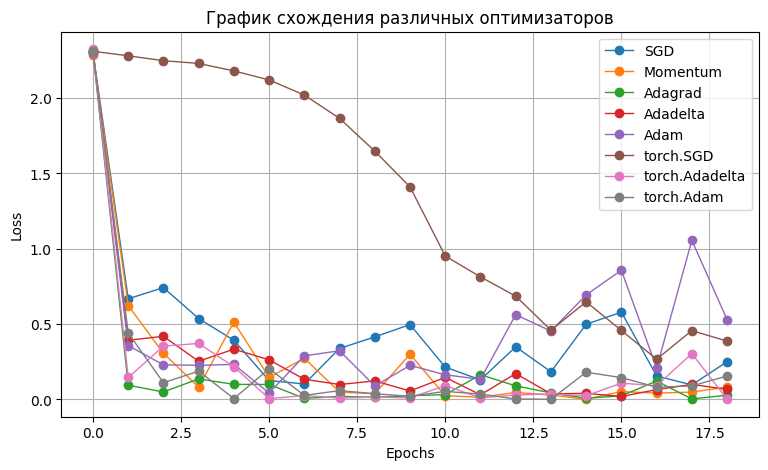

In [25]:
plt.figure(figsize=(9, 5))
for losses, label in zip(networks_losses, networks_labels):
    plt.plot(losses, '-o', label=label, linewidth=1.0)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('График схождения различных оптимизаторов')
plt.grid()
plt.legend()
plt.show()

**Вывод:**

1. метод torch.optim.SGD зависит от параметров, поэтому долгое схождение

2. Остальные методы +- сходятся одинаково, на данной выборке. Но уже после 10-ой эпохи пошло заметное переобучение, в данном случае не на что не влияет